In [ ]:
!pip install geopandas
!pip install geopy
!pip install h3
!pip install geojson

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopy as gp

import folium
import plotly.express as px
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes
import h3
from shapely.geometry import Polygon
import geojson
from geojson import Feature, Point, FeatureCollection, Polygon

In [ ]:
# Read the csv file
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/hack2/Dataset_1.csv')
df=df[df['city']=='Bangalore'].drop(columns=['Unnamed: 12', 'Unnamed: 13']) # only the fata points of bangalore have been considered for this analysis
df['poi_type'] = df['poi_type'].fillna('NA') # filling the null values with string 'NA
df['name'] = df['name'].fillna('NA')  # filling the null values with string 'NA

In [ ]:
df.shape

(29755, 12)

In [ ]:
df.head(5)

,source,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand
0,OSM,POI_1003_6612393918,Parle,shop.food.bakery,13.049754,77.492895,NaN,Bangalore,Karnataka,India,NaN,NaN
1,OSM,POI_1003_6613030600,The Black Pearl,food.restaurant,12.939213,77.694700,NaN,Bangalore,Karnataka,India,NaN,NaN
2,OSM,POI_1003_4668296373,Temple,leisure.worship.temple,12.940448,77.693816,NaN,Bangalore,Karnataka,India,NaN,NaN
3,OSM,POI_1003_3771995983,Kadubeesanahalli Underpass,transport.lane.underpass,12.939450,77.695305,NaN,Bangalore,Karnataka,India,NaN,NaN
4,OSM,POI_1003_2413350412,NA,health.wellbeing.swimming_pool,12.940660,77.693607,NaN,Bangalore,Karnataka,India,NaN,NaN


In [ ]:
df.columns

Index(['source', 'poi_code', 'name', 'poi_type', 'lat', 'long', 'address',
       'city', 'state', 'country', 'pin_code', 'brand'],
      dtype='object')

In [ ]:
df.describe()

,lat,long
count,29755.000000,29755.000000
mean,12.971499,77.611536
std,0.055139,0.056520
min,12.663725,77.336965
25%,12.939506,77.572352
50%,12.972892,77.612569
75%,13.000775,77.642294
max,13.223185,77.811621


**The original data for bangalore has around ~12000 missing values for poi_type, around 2500+ of them have been filled, some using the function described below where the information from the 'name' is use to fill the missing 'poi_type'. And several hundreds have been filled manually using 'Open Street Map'. Also, Some given poi_type were altered, some deleted and some new ones added**

In [ ]:
def fill (x):
  if ((x['poi_type']=='NA') and (('Circle' in x['name'])or('Cross' in x['name'])or('Junction' in x['name']))):
    return 'transport.lane.crossroads'
  if ((x['poi_type']=='NA') and (('Medicals' in x['name'])or('Pharmacy' in x['name'])or('medicals' in x['name']))):
    return 'health.service.pharmacy'
  if ((x['poi_type']=='NA') and (('Laundry' in x['name'])or('Dhobi' in x['name'])or('Cleaner' in x['name']))):
    return 'service.amenity.laundry'
  if ((x['poi_type']=='NA') and (('tailor' in x['name'])or('Tailor' in x['name']))):
    return 'service.amenity.tailor'
  if ((x['poi_type']=='NA') and ('Blood' in x['name'])):
    return 'health.service.blood_bank'
  if ((x['poi_type']=='NA') and (('Temple' in x['name'])or('temple' in x['name'])or('Mandir' in x['name'])or('mandir' in x['name']))):
    return 'leisure.worship.temple'
  if ((x['poi_type']=='NA') and (('Masjid' in x['name'])or('masjid' in x['name'])or('Mosque' in x['name']))):
    return 'leisure.worship.masjid'
  if ((x['poi_type']=='NA') and (('church' in x['name'])or('Church' in x['name']))):
    return 'leisure.worship.church'
  if ((x['poi_type']=='NA') and (('Tiles' in x['name'])or('Sanitary' in x['name']))):
    return 'shop.home.hardware'
  if ((x['poi_type']=='NA') and ('Garage' in x['name'])):
    return 'auto.car.wash'
  if ((x['poi_type']=='NA') and (('Bakery' in x['name'])or('Sweets' in x['name'])or('Cafe' in x['name']))):
    return 'food.restaurant.cafe'
  if ((x['poi_type']=='NA') and (('Apartment' in x['name'])or('apartment' in x['name'])or('Residency' in x['name'])or('Layout' in x['name'])or('layout' in x['name'])or('Colony' in x['name']))):
    return 'building.private.residency'
  if ((x['poi_type']=='NA') and (('Theater' in x['name'])or('Talkies' in x['name'])or('Theatre' in x['name']))):
    return 'leisure.indoor.theatre'
  if ((x['poi_type']=='NA') and (('college' in x['name'])or('College' in x['name'])or('Institution' in x['name'])or('Institution' in x['name']))):
    return 'facility.education.college'
  #if ((x['poi_type']=='NA') and (('nursing' in x['name'])or('Nursing' in x['name'])or('Institution' in x['name'])or('Institution' in x['name']))):
    #return 'facility.education.college'
  if ((x['poi_type']=='NA') and (('police' in x['name'])or('Police' in x['name']))):
    return 'service.govt.police'
  if ((x['poi_type']=='NA') and (('Palm' in x['name'])or('Coconut' in x['name'])or('Mango' in x['name'])or('Jasmine' in x['name'])or('Tamarind' in x['name'])or('Cotton Tree' in x['name'])or('Indian Beech' in x['name'])or('Indian Elm' in x['name'])or('Copperpod' in x['name'])or('Peeple' in x['name']))):
    return 'leisure.outdoor.tree'
  if ((x['poi_type']=='NA') and (('Banyan' in x['name'])or('Neem' in x['name'])or('Pride Of India' in x['name'])or('Indian Almond' in x['name'])or('Royal poinciana' in x['name'])or('Bullet wood' in x['name'])or('Balckboard Tree' in x['name'])or('Sita Ashok' in x['name'])or('Copperpod' in x['name'])or('Peeple' in x['name']))):
    return 'leisure.outdoor.tree'
  if ((x['poi_type']=='NA') and (('Post Office' in x['name'])or('post office' in x['name']))):
    return 'service.govt.post'     
  if ((x['poi_type']=='NA') and (('Park' in x['name']))):
    return 'leisure.outdoor.park'
  if ((x['poi_type']=='NA') and (('Garden' in x['name']))):
    return 'leisure.outdoor.garden'
  if ((x['poi_type']=='NA') and (('Tailor' in x['name'])or('tailor' in x['name']))):
    return 'service.amenity.tailor'    
  #if ( (('Software' in x['name'])or('software' in x['name']))):
    #return 'service.technology.software_IT' 
  if ((x['poi_type']=='NA') and (('School' in x['name']))):
    return 'facility.education.school'      
  else: return x['poi_type']

In [ ]:
df['poi_type']=df.apply (fill, axis=1) 

print ((df['poi_type']=='NA').sum())

9083


**the remaining 9000 data points that could not be filled have not been considered for further analysis**

In [ ]:
#from google.colab import files
#dfa=df[df['poi_type']=='NA']
#dfa.to_csv('nulls.csv', index = None, header=True, encoding = 'utf-8-sig')
#files.download('nulls.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#df[ (df['name'].str.contains('Paper')) | (df['name'].str.contains('Krona')) ]

**A list of the different poi_types and their counts**

In [ ]:
print(df['poi_type'].value_counts().sort_index().to_string())

NA                                         9083
auto.bicycle                                 49
auto.bicycle.rental                          38
auto.bicycle.repair                           6
auto.car.dealership                         134
auto.car.parts                               76
auto.car.rental                               9
auto.car.wash                                27
auto.motorcycle.dealership                  111
auto.service.driving_school                  15
auto.service.repair                          41
building.commercial.industry                 34
building.commercial.office                  487
building.commerical.industry                  3
building.embassy                              4
building.govt.office                         69
building.private.residency                  429
facility.community.cemetery                   5
facility.community.hall                     123
facility.community.library                   54
facility.community.recycling            

**a display of all the available data points**

**bangalore shape map**

In [ ]:
street_map = gpd.read_file('/content/gdrive/My Drive/Colab Notebooks/hack2/mygeodata/bbmp-wards-map-polygon.shp')

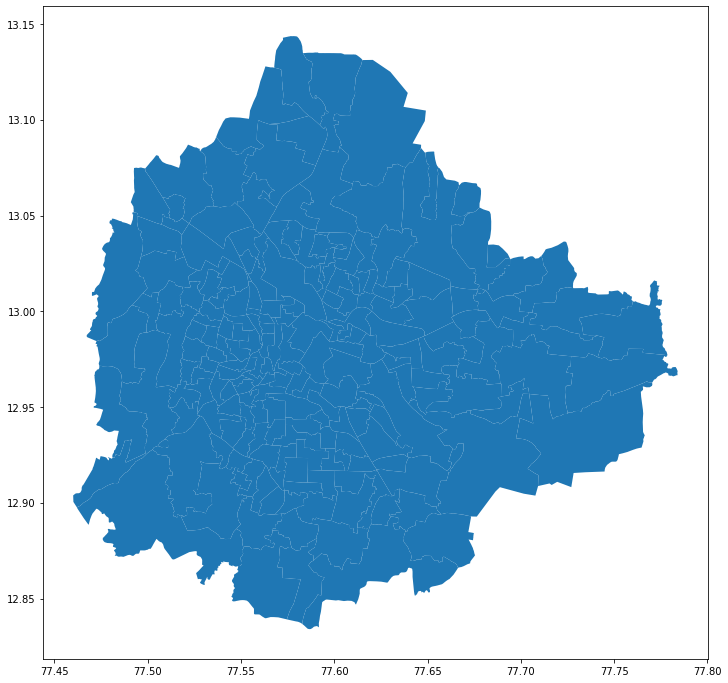

In [ ]:
fig,ax=plt.subplots(figsize=(12,12))
street_map.plot(ax=ax)

In [ ]:
dfa=df[df['poi_type']!='NA'] # dropping data points for which poi_type is misssing
geom= [Point(xy) for xy in zip(dfa['long'], dfa['lat'])]
crs ={'init':'epsg:4326'}
dfa_geo = gpd.GeoDataFrame (dfa, crs=crs,geometry=geom) # appending co-ordinate point to the dataset

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



In [ ]:
dfa_geo.head()

,source,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,geometry
0,OSM,POI_1003_6612393918,Parle,shop.food.bakery,13.049754,77.492895,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.49289 13.04975)
1,OSM,POI_1003_6613030600,The Black Pearl,food.restaurant,12.939213,77.694700,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69470 12.93921)
2,OSM,POI_1003_4668296373,Temple,leisure.worship.temple,12.940448,77.693816,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69382 12.94045)
3,OSM,POI_1003_3771995983,Kadubeesanahalli Underpass,transport.lane.underpass,12.939450,77.695305,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69531 12.93945)
4,OSM,POI_1003_2413350412,NA,health.wellbeing.swimming_pool,12.940660,77.693607,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69361 12.94066)


In [ ]:
dfa.describe()

,lat,long
count,20672.000000,20672.000000
mean,12.967153,77.609876
std,0.052548,0.053632
min,12.678724,77.380366
25%,12.934769,77.571226
50%,12.970071,77.604449
75%,12.996681,77.641997
max,13.223185,77.804060


**shape map with data points for whic poi_type data is availabe**

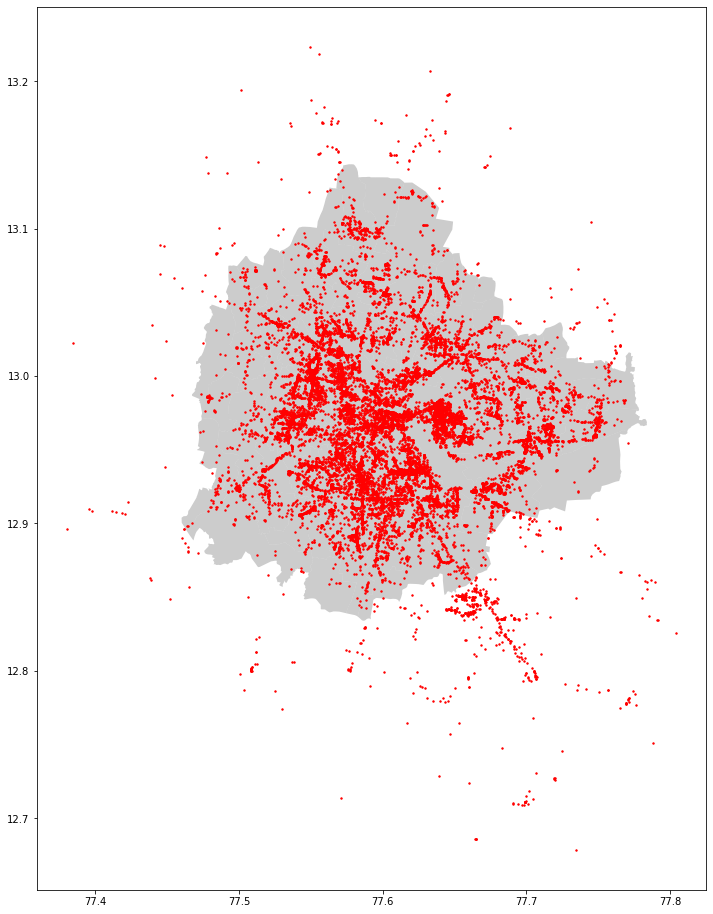

In [ ]:
fig,ax=plt.subplots(figsize=(12,25))
street_map.plot(ax=ax, color='grey', alpha=0.4)
dfa_geo.plot(ax=ax, markersize=2, color='red', marker='o')

**hospitals and blood banks display**

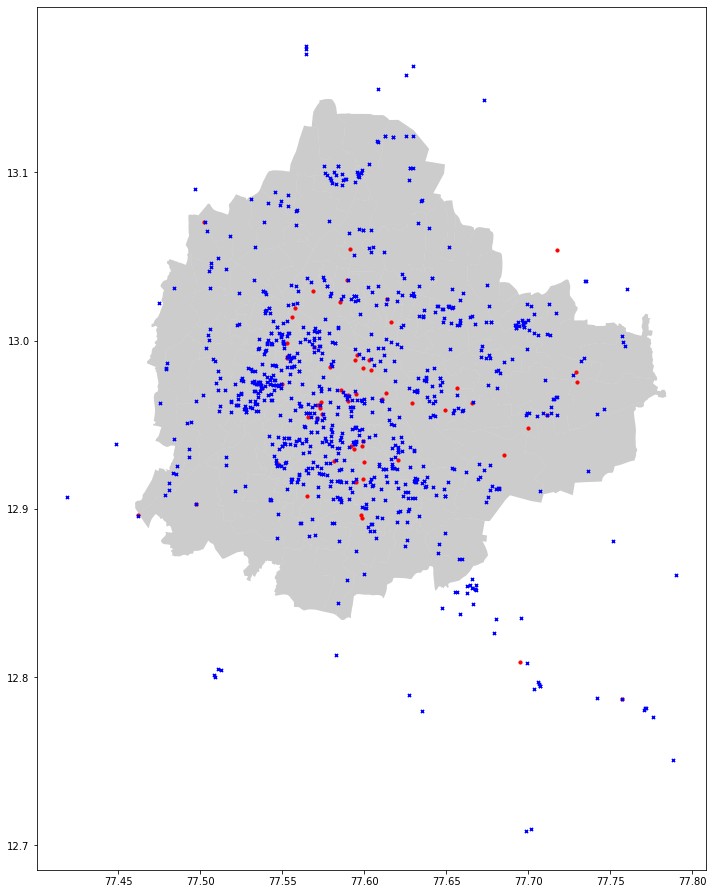

In [ ]:
fig,ax=plt.subplots(figsize=(12,25))
street_map.plot(ax=ax, color='grey', alpha=0.4)
dfa_geo[dfa_geo['poi_type']=='health.service.blood_bank'].plot(ax=ax,  markersize=10, color='red', marker='o')
dfa_geo[dfa_geo['poi_type']=='health.hospital.general'].plot(ax=ax,  markersize=10, color='blue', marker='x')
plt.show()

In [ ]:
H3_res = 8
def geo_to_h3(row):
  return h3.geo_to_h3(lat=row.lat,lng=row['long'],resolution = H3_res)

dfa_geo['h3_cell'] = dfa_geo.apply(geo_to_h3,axis=1)

In [ ]:
dfa_geo.head()

,source,poi_code,name,poi_type,lat,long,address,city,state,country,pin_code,brand,geometry,h3_cell
0,OSM,POI_1003_6612393918,Parle,shop.food.bakery,13.049754,77.492895,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.49289 13.04975),886014598dfffff
1,OSM,POI_1003_6613030600,The Black Pearl,food.restaurant,12.939213,77.694700,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69470 12.93921),8861892097fffff
2,OSM,POI_1003_4668296373,Temple,leisure.worship.temple,12.940448,77.693816,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69382 12.94045),8861892097fffff
3,OSM,POI_1003_3771995983,Kadubeesanahalli Underpass,transport.lane.underpass,12.939450,77.695305,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69531 12.93945),8861892097fffff
4,OSM,POI_1003_2413350412,NA,health.wellbeing.swimming_pool,12.940660,77.693607,NaN,Bangalore,Karnataka,India,NaN,NaN,POINT (77.69361 12.94066),8861892097fffff


In [ ]:
def add_geometry(row):
  points = h3.h3_to_geo_boundary(row['h3_cell'], True)
  return Polygon(points)

**environment score**

In [ ]:
dfa_e = (dfa_geo[ (dfa_geo['poi_type'].str.contains('tree')) | (dfa_geo['poi_type'].str.contains('park'))  | (dfa_geo['poi_type'].str.contains('garden')) ].groupby('h3_cell').poi_code.agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
dfa_e['count'] =(dfa_e['ids'].apply(lambda poi_code:len(poi_code)))

#Apply function
dfa_e['geometry'] = (dfa_e.apply(add_geometry,axis=1))
dfa_e['count'] = dfa_e['count']*10
dfa_e = dfa_e.drop(columns='ids')

**education score**

In [ ]:
dfa_ed = (dfa_geo[ (dfa_geo['poi_type'].str.contains('education'))].groupby('h3_cell').poi_code.agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
dfa_ed['count'] =(dfa_ed['ids'].apply(lambda poi_code:len(poi_code)))

#Apply function
dfa_ed['geometry'] = (dfa_ed.apply(add_geometry,axis=1))
dfa_ed['count'] = dfa_ed['count']*10
dfa_ed = dfa_ed.drop(columns='ids')

**combined score**

In [ ]:
for i in dfa_ed.index:
  #print(row)
  if sum(dfa_e['h3_cell']==dfa_ed.loc[i,'h3_cell'])==0:
    dfa_e.loc[len(dfa_e.index)] = [dfa_ed.loc[i,'h3_cell'], dfa_ed.loc[i,'count'], dfa_ed.loc[i,'geometry']] 
  else:
    dfa_e.loc[dfa_e['h3_cell']==dfa_ed.loc[i,'h3_cell'], 'count'] = dfa_e.loc[dfa_e['h3_cell']==dfa_ed.loc[i,'h3_cell'], 'count']  + dfa_ed.loc[i,'count']

**health score**

In [ ]:
dfa_h = (dfa_geo[ (dfa_geo['poi_type'].str.contains('health'))].groupby('h3_cell').poi_code.agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
dfa_h['count'] =(dfa_h['ids'].apply(lambda poi_code:len(poi_code)))

#Apply function
dfa_h['geometry'] = (dfa_h.apply(add_geometry,axis=1))
dfa_h['count'] = dfa_h['count']*5
dfa_h = dfa_h.drop(columns='ids')

**combined score**

In [ ]:
for i in dfa_h.index:
  #print(row)
  if sum(dfa_e['h3_cell']==dfa_h.loc[i,'h3_cell'])==0:
    dfa_e.loc[len(dfa_e.index)] = [dfa_h.loc[i,'h3_cell'], dfa_h.loc[i,'count'], dfa_h.loc[i,'geometry']] 
  else:
    dfa_e.loc[dfa_e['h3_cell']==dfa_h.loc[i,'h3_cell'], 'count'] = dfa_e.loc[dfa_e['h3_cell']==dfa_h.loc[i,'h3_cell'], 'count']  + dfa_h.loc[i,'count']

**leisure score**

In [ ]:
dfa_l = (dfa_geo[ (dfa_geo['poi_type'].str.contains('leisure')) | (dfa_geo['poi_type'].str.contains('community')) ].groupby('h3_cell').poi_code.agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
dfa_l['count'] =(dfa_l['ids'].apply(lambda poi_code:len(poi_code)))

#Apply function
dfa_l['geometry'] = (dfa_l.apply(add_geometry,axis=1))
dfa_l['count'] = dfa_l['count']*10
dfa_l = dfa_l.drop(columns='ids')

In [ ]:
for i in dfa_l.index:
  #print(row)
  if sum(dfa_e['h3_cell']==dfa_l.loc[i,'h3_cell'])==0:
    dfa_e.loc[len(dfa_e.index)] = [dfa_l.loc[i,'h3_cell'], dfa_l.loc[i,'count'], dfa_l.loc[i,'geometry']] 
  else:
    dfa_e.loc[dfa_e['h3_cell']==dfa_l.loc[i,'h3_cell'], 'count'] = dfa_e.loc[dfa_e['h3_cell']==dfa_l.loc[i,'h3_cell'], 'count']  + dfa_l.loc[i,'count']

**employment/service score**

In [ ]:
dfa_emp = (dfa_geo[ (dfa_geo['poi_type'].str.contains('technology')) | (dfa_geo['poi_type'].str.contains('industry')) | (dfa_geo['poi_type'].str.contains('service')) ].groupby('h3_cell').poi_code.agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexagon
dfa_emp['count'] =(dfa_emp['ids'].apply(lambda poi_code:len(poi_code)))

#Apply function
dfa_emp['geometry'] = (dfa_emp.apply(add_geometry,axis=1))
dfa_emp['count'] = dfa_emp['count']*10
dfa_emp = dfa_emp.drop(columns='ids')

In [ ]:
for i in dfa_emp.index:
  #print(row)
  if sum(dfa_e['h3_cell']==dfa_emp.loc[i,'h3_cell'])==0:
    dfa_e.loc[len(dfa_e.index)] = [dfa_emp.loc[i,'h3_cell'], dfa_emp.loc[i,'count'], dfa_emp.loc[i,'geometry']] 
  else:
    dfa_e.loc[dfa_e['h3_cell']==dfa_emp.loc[i,'h3_cell'], 'count'] = dfa_e.loc[dfa_e['h3_cell']==dfa_emp.loc[i,'h3_cell'], 'count']  + dfa_emp.loc[i,'count']

**amenity**

In [ ]:
dfa_a = (dfa_geo[ (dfa_geo['poi_type'].str.contains('amenity')) | (dfa_geo['poi_type'].str.contains('transport')) | (dfa_geo['poi_type'].str.contains('food')) ].groupby('h3_cell').poi_code.agg(list).to_frame("ids").reset_index())
# Let's count each points inside the hexago
dfa_a['count'] =(dfa_a['ids'].apply(lambda poi_code:len(poi_code)))

#Apply function
dfa_a['geometry'] = (dfa_a.apply(add_geometry,axis=1))
dfa_a['count'] = dfa_a['count']*5
dfa_a = dfa_a.drop(columns='ids')

In [ ]:
for i in dfa_a.index:
  #print(row)
  if sum(dfa_e['h3_cell']==dfa_a.loc[i,'h3_cell'])==0:
    dfa_e.loc[len(dfa_e.index)] = [dfa_a.loc[i,'h3_cell'], dfa_a.loc[i,'count'], dfa_a.loc[i,'geometry']] 
  else:
    dfa_e.loc[dfa_e['h3_cell']==dfa_a.loc[i,'h3_cell'], 'count'] = dfa_e.loc[dfa_e['h3_cell']==dfa_a.loc[i,'h3_cell'], 'count']  + dfa_a.loc[i,'count']

In [ ]:
def hexagons_dataframe_to_geojson(df_hex, hex_id_field,geometry_field, value_field):

    list_features = []

    for i, row in df_hex.iterrows():
        feature = Feature(geometry = row[geometry_field],
                          id = row[hex_id_field],
                          properties = {"value": row[value_field]})
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    return feat_collection

**FINAL CLUSTERING**

In [ ]:
geojson_obj = (hexagons_dataframe_to_geojson
                (dfa_e,
                 hex_id_field='h3_cell',
                 value_field='count',
                 geometry_field='geometry'))



fig = (px.choropleth_mapbox(
                    dfa_e, 
                    geojson=geojson_obj, 
                    locations='h3_cell', 
                    color='count',
                    color_continuous_scale="Viridis",
                    range_color=(0,dfa_e['count'].mean()),                  
                    mapbox_style='carto-positron',
                    zoom=11,
                    center = {"lat": 12.967153, "lon": 77.609876},
                    opacity=0.7,
                    labels={'count':'# '}))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, width=1500, height=1000)

fig.show()

**the above color clustering is based on cumulative urbanisation score, that is calculated from the quality of life available in that cluster, the regions with colors closer to yellow are more urbanised than the darker regions towards violet**

## **END**